# (1) Load albums data in Toodler Group

In [1]:
import os, re, nltk
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize 


df_temp = pd.read_csv("Album_AgeGroup.csv")
df_toodler = df_temp[df_temp['Age Group'] == "Toodler"]
df_toodler.head()

,Age,Title,Artist,Year,Description,Age Group
0,2,Sesame Street: Halloween Collection,Sesame Street,2012,"Playful, not-so-spooky Halloween songs for th...",Toodler
1,2,A Child's Celebration of Rock 'n' Roll,Various Artists,1996,Songs to get toddlers and teens energized.,Toodler
2,2,Wake up Jeff,The Wiggles,2000,Songs and scenes certain to keep kids attenti...,Toodler
3,2,Toot Toot!,The Wiggles,2001,Gets little couch potatoes up and moving.,Toodler
4,2,A Child's Celebration of Classical Music,Various Artists,1999,Talented celebs promote classics for kids.,Toodler


# (2) For each album, use Genius API to find the lyrics. Save to a dataframe.

In [2]:
import lyricsgenius
df_toodler.loc[:,'AlbumLyricsFileName'] = df_toodler.apply(lambda x:"./lyrics/" + lyricsgenius.utils.sanitize_filename(x['Artist'] + "_" + x['Title']) +".json", axis = 1)
df_toodler.loc[:,'AlbumLyricsFound'] =  df_toodler.loc[:,'AlbumLyricsFileName'].apply(os.path.isfile)
df_toodler = df_toodler[df_toodler['AlbumLyricsFound'] == True]  #Skip albums not found in Genius API


import json
df = pd.DataFrame(columns=['Album Title','Artist', 'Song Title', 'Lyrics'])
for index, row in df_toodler.iterrows():
    filename = row['AlbumLyricsFileName']
    album_title = row['Title']
    artist = row['Artist']
    jsonfile = json.load(open(filename))
    if 'tracks' not in jsonfile:
        break
    for track in jsonfile['tracks']:
        if 'song' in track:
            song = track['song']
            if 'lyrics' in song and len(song['lyrics'])>0:
                lyrics = song['lyrics']
                title = song['title']
                df2 = {'Album Title': album_title, 'Artist': artist, 'Song Title': title, 'Lyrics': lyrics}
                df = df.append(df2, ignore_index = True)

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Album Title,Artist,Song Title,Lyrics
0,Sesame Street: Halloween Collection,Sesame Street,Sammy The Snake,"(spoken)\nSssss! Say hey! I'm Sammy the snake,..."
1,Wake up Jeff,The Wiggles,We Like to Say Hello,The Big Red Car rolls along the street\nAnd to...
2,Wake up Jeff,The Wiggles,Having Fun At The Beach,Greg: (singing) Having fun at the beach\nMurra...
3,Wake up Jeff,The Wiggles,Wake Up Jeff,"Wake up, Jeff\nEverybody's wiggling\nWake up, ..."
4,Wake up Jeff,The Wiggles,Dorothy (Would You Like to Dance),"Spoken:\nCome on everybody, let's dance\nDorot..."


# (3) Pre-processing Song Lyrics

In [3]:
import nltk
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)

def preprocess(data):
    data_processed=[]
    for e in data['Lyrics']:       
        e = re.sub("[^a-zA-Z]", " ", e) # find alphabets
        e = e.lower()                   # convert to lower case
        e = nltk.word_tokenize(e)       # tokenize words
        e = [word for word in e if not word in set(stopwords.words("english"))]        # remove stopwords
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e=" ".join(e)
        
        data_processed.append(e)
    return data_processed 

df["Lyrics_preprocessed"] = preprocess(df)
df.to_csv("toodler_lyrics_preprocessed.csv", index = False)

path = os.path.join("toodler_lyrics_preprocessed.csv")
df = pd.read_csv(path)
df.fillna('', inplace=True)

df.head(3)

,Album Title,Artist,Song Title,Lyrics,Lyrics_preprocessed
0,Sesame Street: Halloween Collection,Sesame Street,Sammy The Snake,"(spoken)\nSssss! Say hey! I'm Sammy the snake,...",spoken sss say hey sammy snake tell people som...
1,Wake up Jeff,The Wiggles,We Like to Say Hello,The Big Red Car rolls along the street\nAnd to...,big red car roll along street people meet like...
2,Wake up Jeff,The Wiggles,Having Fun At The Beach,Greg: (singing) Having fun at the beach\nMurra...,greg singing fun beach murray anthony jeff fun...


# (4) Plot the Word Cloud

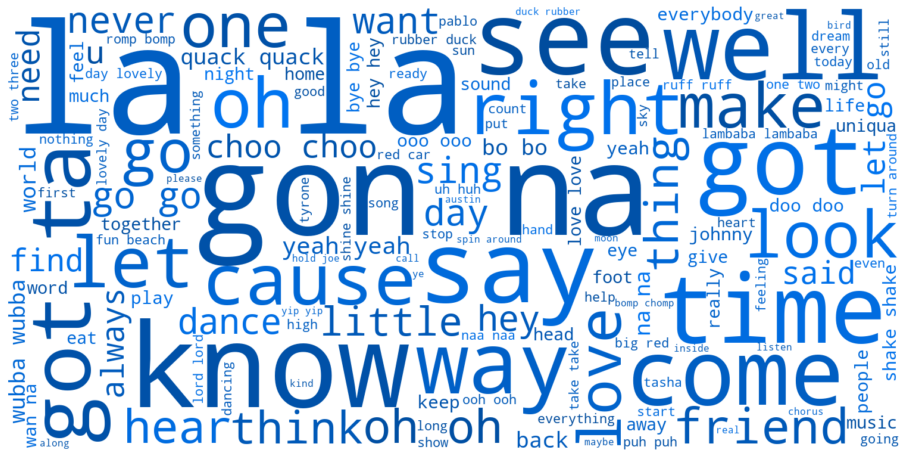

In [4]:
# color function for the wordcloud
def color_wc(word=None,font_size=None,position=None, orientation=None,font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,color_func=color_wc,max_words=150, max_font_size=256,random_state=42)
wc.generate(' '.join(df['Lyrics_preprocessed']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig("Plot2_ToodlerLyrics_WordCloud.jpg")
plt.show()